# 5. Model the Solution

## Question 3: Can we forecast the price of Onion in Bangalore?

We will use the following models to build a better forecast for Onion prices. All these models are based on stationary time series
- Mean (Constant) Model
- Linear Trend Model
- Random Walk Model
- Simple Moving Average (SMA)
- Simple Exponential Smoothing (SES)
- Holt Winter Model
- ARIMA

**Statistical stationarity**: A stationary time series is one whose statistical properties such as mean, variance, autocorrelation, etc. are all constant over time. Most statistical forecasting methods are based on the assumption that the time series can be rendered approximately stationary (i.e., "stationarized") through the use of mathematical transformations. A stationarized series is relatively easy to predict: you simply predict that its statistical properties will be the same in the future as they have been in the past! 

### Preprocessing to get the tidy dataframe

In [1]:
# Import the library we need, which is Pandas and Matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import statsmodel
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
# Set some parameters to get good visuals - style to ggplot and size to 15,10
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 10)

In [3]:
# Read the csv file of Monthwise Quantity and Price csv file we have.
df = pd.read_csv('MonthWiseMarketArrivals_clean.csv')

In [4]:
# Changing the date column to a Time Interval columnn
df.date = pd.DatetimeIndex(df.date)

In [5]:
# Change the index to the date column
df.index = pd.PeriodIndex(df.date, freq='M')

In [6]:
# Sort the data frame by date
df = df.sort_values(by = "date")

In [7]:
df.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date
1996-01,LASALGAON(MS),January,1996,225063,160,257,226,MS,LASALGAON,1996-01-01
1996-02,LASALGAON(MS),February,1996,196164,133,229,186,MS,LASALGAON,1996-02-01
1996-03,LASALGAON(MS),March,1996,178992,155,274,243,MS,LASALGAON,1996-03-01
1996-04,LASALGAON(MS),April,1996,192592,136,279,254,MS,LASALGAON,1996-04-01
1996-05,LASALGAON(MS),May,1996,237574,154,312,269,MS,LASALGAON,1996-05-01


In [8]:
dfBang = df.loc[df.city == "BANGALORE"].copy()

In [9]:
dfBang.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date
2004-01,BANGALORE,January,2004,227832,916,1066,991,KNT,BANGALORE,2004-01-01
2004-02,BANGALORE,February,2004,225133,741,870,793,KNT,BANGALORE,2004-02-01
2004-03,BANGALORE,March,2004,221952,527,586,556,KNT,BANGALORE,2004-03-01
2004-04,BANGALORE,April,2004,185150,419,518,465,KNT,BANGALORE,2004-04-01
2004-05,BANGALORE,May,2004,137390,400,516,455,KNT,BANGALORE,2004-05-01


In [10]:
# Drop redundant columns
dfBang = dfBang.drop(["market", "month", "year", "state", "city", "priceMin", "priceMax"], axis = 1)

In [11]:
dfBang.head()

,quantity,priceMod,date
2004-01,227832,991,2004-01-01
2004-02,225133,793,2004-02-01
2004-03,221952,556,2004-03-01
2004-04,185150,465,2004-04-01
2004-05,137390,455,2004-05-01


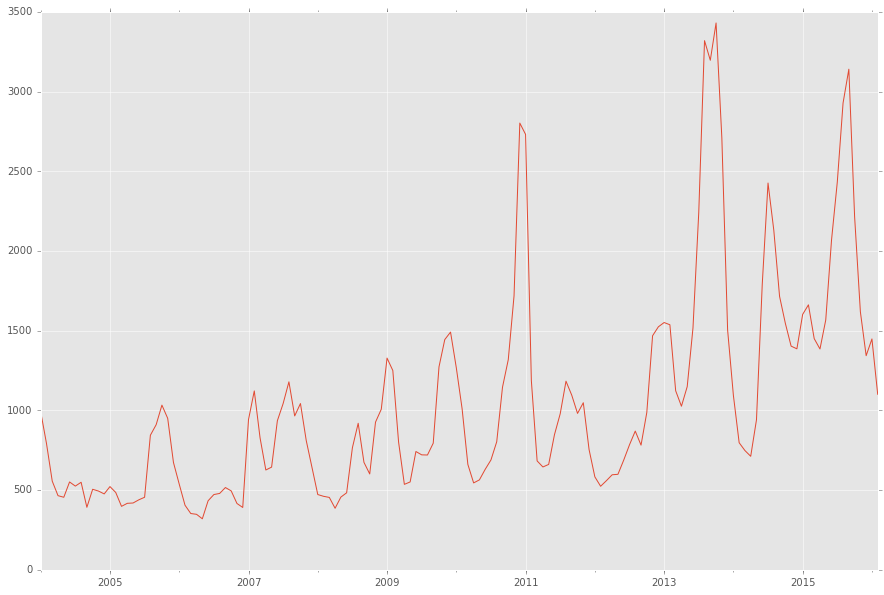

In [12]:
dfBang.priceMod.plot()

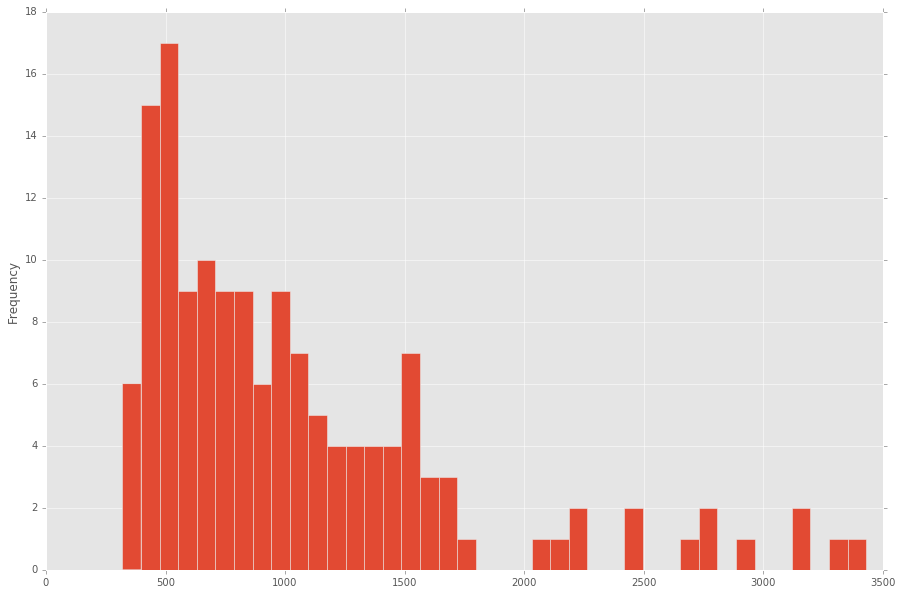

In [13]:
dfBang.priceMod.plot(kind = "hist", bins = 40)

In [14]:
dfBang['priceModLog'] = np.log(dfBang.priceMod)

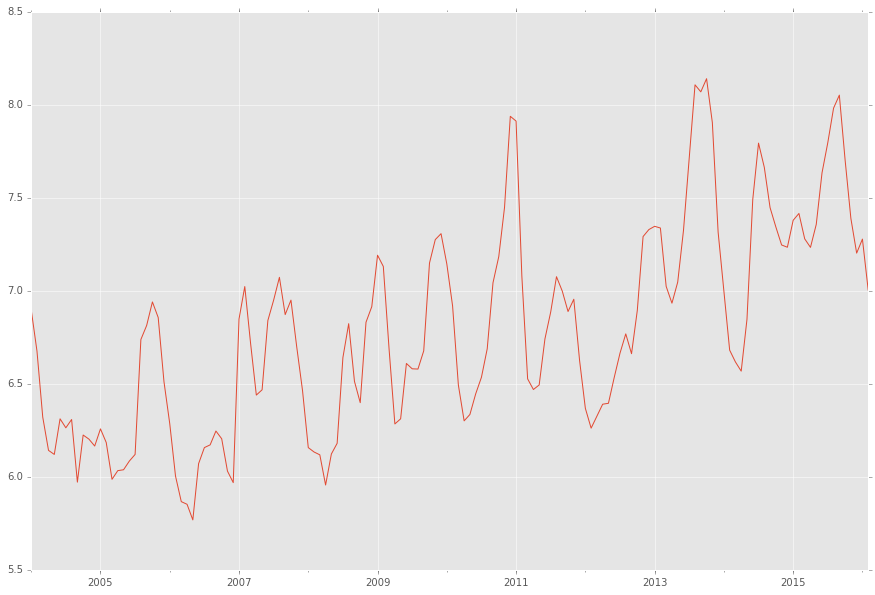

In [15]:
dfBang.priceModLog.plot()

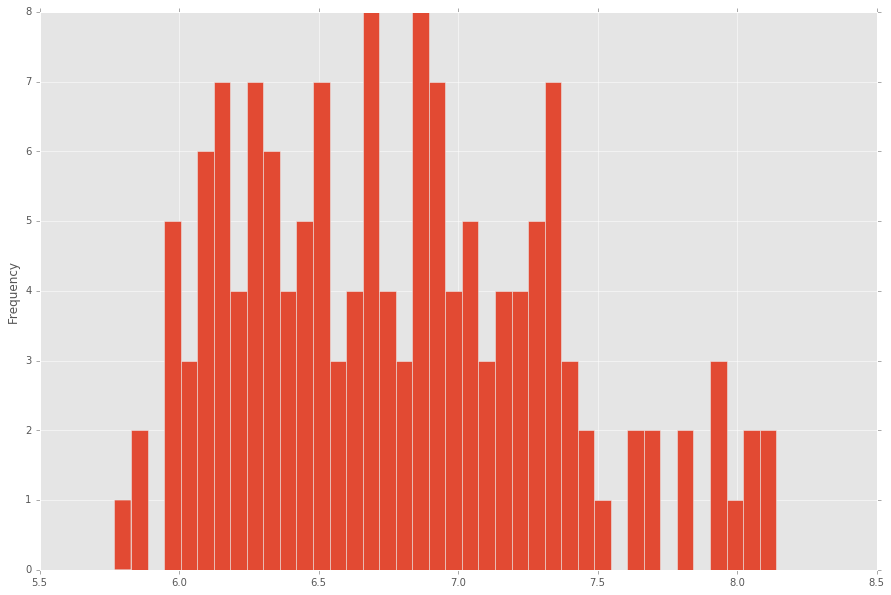

In [16]:
dfBang.priceModLog.plot(kind = "hist", bins = 40)

## Getting ready for prediction

In [17]:
dfBang.dtypes

quantity                int64
priceMod                int64
date           datetime64[ns]
priceModLog           float64
dtype: object

In [18]:
# What is the starting month of our data
dfBang.date.min()

Timestamp('2004-01-01 00:00:00')

In [28]:
# Convert date in datetimedelta figure starting from zero
dfBang["timeIndex"] = dfBang.date - dfBang.date.min()

In [20]:
dfBang.head()

,quantity,priceMod,date,priceModLog,timeIndex
2004-01,227832,991,2004-01-01,6.898715,0 days
2004-02,225133,793,2004-02-01,6.675823,31 days
2004-03,221952,556,2004-03-01,6.320768,60 days
2004-04,185150,465,2004-04-01,6.142037,91 days
2004-05,137390,455,2004-05-01,6.120297,121 days


In [21]:
dfBang.dtypes

quantity                 int64
priceMod                 int64
date            datetime64[ns]
priceModLog            float64
timeIndex      timedelta64[ns]
dtype: object

In [79]:
# Convert to months using the timedelta function
dfBang["timeIndex"] =  dfBang["timeIndex"]/np.timedelta64(1, 'M')

In [80]:
dfBang.timeIndex.head()

2004-01    0.000000
2004-02    1.018501
2004-03    1.971293
2004-04    2.989794
2004-05    3.975441
Freq: M, Name: timeIndex, dtype: float64

In [82]:
# Round the number to 0
dfBang["timeIndex"] = dfBang["timeIndex"].round(0).astype(int)

In [83]:
dfBang.timeIndex.head()

2004-01    0
2004-02    1
2004-03    2
2004-04    3
2004-05    4
Freq: M, Name: timeIndex, dtype: int64

For prediction we will slice the data in train and test datasets. We will take the first 120 months as training data and then predict the value on the balance months to find the prediction accuracy

In [84]:
dfBang.head()

,quantity,priceMod,date,priceModLog,timeIndex,priceMean
2004-01,227832,991,2004-01-01,6.898715,0,785.692536
2004-02,225133,793,2004-02-01,6.675823,1,785.692536
2004-03,221952,556,2004-03-01,6.320768,2,785.692536
2004-04,185150,465,2004-04-01,6.142037,3,785.692536
2004-05,137390,455,2004-05-01,6.120297,4,785.692536


In [95]:
# We want the first 120 rows
train = dfBang.iloc[:120,].copy()
train.tail()

,quantity,priceMod,date,priceModLog,timeIndex,priceMean
2013-08,511174,3319,2013-08-01,8.107419,115,785.692536
2013-09,1289187,3196,2013-09-01,8.069655,116,785.692536
2013-10,1639032,3430,2013-10-01,8.140316,117,785.692536
2013-11,710266,2709,2013-11-01,7.904335,118,785.692536
2013-12,628220,1504,2013-12-01,7.315884,119,785.692536


In [96]:
test = dfBang.iloc[120:,].copy()
test.head()

,quantity,priceMod,date,priceModLog,timeIndex,priceMean
2014-01,606710,1094,2014-01-01,6.997596,120,785.692536
2014-02,522132,797,2014-02-01,6.680855,121,785.692536
2014-03,683236,748,2014-03-01,6.617403,122,785.692536
2014-04,697423,712,2014-04-01,6.568078,123,785.692536
2014-05,591250,941,2014-05-01,6.846943,124,785.692536


## Mean  Model

This very simple forecasting model will be called the "mean model"

In [32]:
train_meanLog_pred = train.priceModLog.mean()
train_meanLog_pred

6.666565540399236

In [44]:
test_meanLog_pred = train_meanLog_pred
test_mean_pred = np.exp(test_meanLog_pred)
test_mean_pred

785.69253605631127

In [59]:
# Let us store this as our Mean Predication Value
dfBang["priceMean"] = test_mean_pred

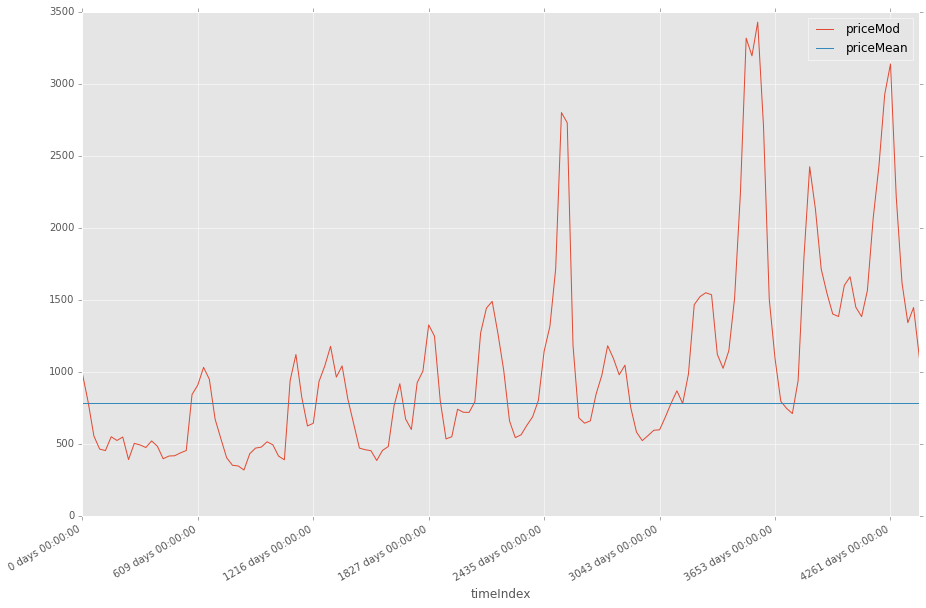

In [60]:
dfBang.plot(kind="line", x="timeIndex", y = ["priceMod", "priceMean"])

**Can we measure the error rate?**

We will use Root Mean Squared Error (RMSE) to calculate our error values

$RMSE = \Sigma \sqrt{ (\hat{y} - y)^2/n} $ , where $\hat{y}$ is  predicted value of y

In [61]:
test_mean_pred = np.exp(train_meanLog_pred)

In [62]:
model_mean_mse = (test.priceMod -  test_mean_pred)**2
model_mean_mse

2014-01      95053.492323
2014-02        127.858741
2014-03       1420.727274
2014-04       5430.589870
2014-05      24120.408357
2014-06    1010643.097061
2014-07    2690608.576269
2014-08    1807162.557615
2014-09     863612.362541
2014-10     578067.439728
2014-11     381068.505041
2014-12     360369.051267
2015-01     666357.875690
2015-02     767914.771363
2015-03     441304.406651
2015-04     359169.436339
2015-05     610441.353214
2015-06    1644312.432086
2015-07    2710328.265837
2015-08    4589481.270069
2015-09    5542763.634781
2015-10    2042919.826485
2015-11     692735.714536
2015-12     310591.609367
2016-01     438651.176796
2016-02      99418.796819
Freq: M, Name: priceMod, dtype: float64

In [63]:
model_mean_mse.count()

26

In [64]:
model_mean_rmse = np.sqrt(model_mean_mse.sum()/model_mean_mse.count())
model_mean_rmse

1051.2643529820582

In [65]:
dfBang.tail()

,quantity,priceMod,date,priceModLog,timeIndex,priceMean
2015-10,1612160,2215,2015-10-01,7.703008,4291 days,785.692536
2015-11,1071872,1618,2015-11-01,7.388946,4322 days,785.692536
2015-12,513186,1343,2015-12-01,7.202661,4352 days,785.692536
2016-01,507223,1448,2016-01-01,7.277939,4383 days,785.692536
2016-02,400359,1101,2016-02-01,7.003974,4414 days,785.692536


## Linear Trend Model

Let us start by plotting a linear trend model between price and time

In [85]:
train.head()

,quantity,priceMod,date,priceModLog,timeIndex
2004-01,227832,991,2004-01-01,6.898715,0
2004-02,225133,793,2004-02-01,6.675823,1
2004-03,221952,556,2004-03-01,6.320768,2
2004-04,185150,465,2004-04-01,6.142037,3
2004-05,137390,455,2004-05-01,6.120297,4


In [86]:
model_linear = smf.ols('priceModLog ~ timeIndex', data = train).fit()

In [87]:
model_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            priceModLog   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     73.76
Date:                Sun, 20 Mar 2016   Prob (F-statistic):           4.23e-14
Time:                        11:41:48   Log-Likelihood:                -62.052
No. Observations:                 120   AIC:                             128.1
Df Residuals:                     118   BIC:                             133.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      6.1155      0.074     82.359      0.000         5.968     6.263
timeIndex      0.0093      0.001      8.588      0.000         0.007     0.011
==============================================================================
Omnibus:                        4.979   Durbin-Watson:                   0.375
Prob(Omnibus):                  0.083   Jarque-Bera (JB):                5.016
Skew:                           0.469   Prob(JB):                       0.0814
Kurtosis:                       2.650   Cond. No.                         137.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [88]:
## Parameters for y = mx + c equation
model_linear.params

Intercept    6.115461
timeIndex    0.009262
dtype: float64

In [89]:
train_linear_pred = model_linear.predict()

In [90]:
train_linear_pred

array([ 6.11546062,  6.12472289,  6.13398515,  6.14324742,  6.15250969,
        6.16177196,  6.17103422,  6.18029649,  6.18955876,  6.19882103,
        6.20808329,  6.21734556,  6.22660783,  6.2358701 ,  6.24513236,
        6.25439463,  6.2636569 ,  6.27291917,  6.28218143,  6.2914437 ,
        6.30070597,  6.30996824,  6.31923051,  6.32849277,  6.33775504,
        6.34701731,  6.35627958,  6.36554184,  6.37480411,  6.38406638,
        6.39332865,  6.40259091,  6.41185318,  6.42111545,  6.43037772,
        6.43963998,  6.44890225,  6.45816452,  6.46742679,  6.47668905,
        6.48595132,  6.49521359,  6.50447586,  6.51373812,  6.52300039,
        6.53226266,  6.54152493,  6.5507872 ,  6.56004946,  6.56931173,
        6.578574  ,  6.58783627,  6.59709853,  6.6063608 ,  6.61562307,
        6.62488534,  6.6341476 ,  6.64340987,  6.65267214,  6.66193441,
        6.67119667,  6.68045894,  6.68972121,  6.69898348,  6.70824574,
        6.71750801,  6.72677028,  6.73603255,  6.74529482,  6.75

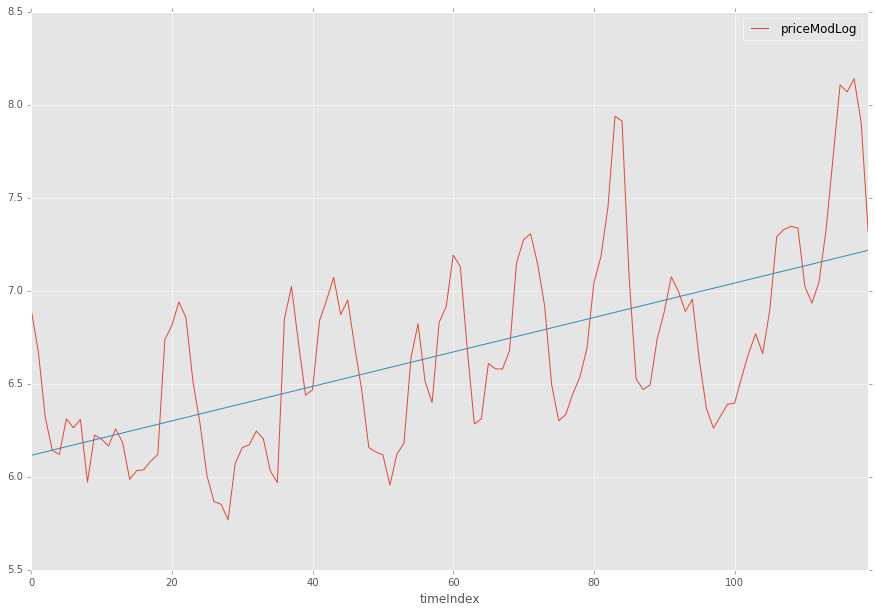

In [91]:
# Plot the prediction line
train.plot(kind="line", x="timeIndex", y = "priceModLog")
plt.plot(train.timeIndex, train_linear_pred, '-')

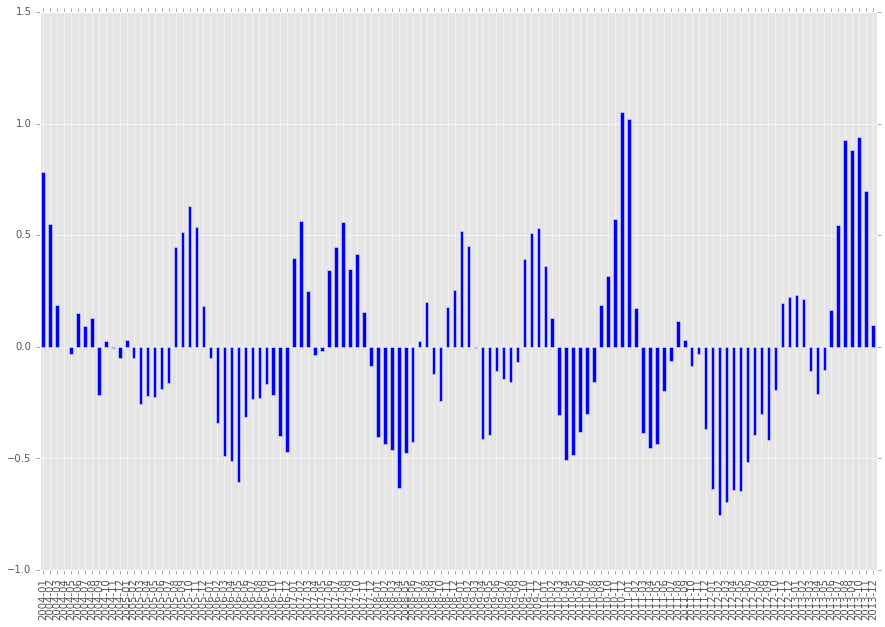

In [92]:
model_linear.resid.plot(kind = "bar")

**Is this a good model?**

What measures can we check to see if the model is good?

It is seen here (and  also evident on the regression line plot, if you look closely) that the linear trend model has a tendency to make an error of the same sign for many periods in a row. This tendency is measured in statistical terms by the **lag-1 autocorrelation and Durbin-Watson statistic**.  If there is no time pattern, the lag-1 autocorrelation should be very close to zero, and the Durbin-Watson statistic ought to be very close to 2, which is not the case here.  If the model has succeeded in extracting all the "signal" from the data, there should be no pattern at all in the errors: the error in the next period should not be correlated with any previous errors. The linear trend model obviously fails the autocorrelation test in this case.


In [97]:
test.head()

,quantity,priceMod,date,priceModLog,timeIndex,priceMean
2014-01,606710,1094,2014-01-01,6.997596,120,785.692536
2014-02,522132,797,2014-02-01,6.680855,121,785.692536
2014-03,683236,748,2014-03-01,6.617403,122,785.692536
2014-04,697423,712,2014-04-01,6.568078,123,785.692536
2014-05,591250,941,2014-05-01,6.846943,124,785.692536


In [98]:
test_linear_pred = model_linear.predict(exog = dict(timeIndex=test.timeIndex))

In [99]:
test_linear_pred

array([ 7.22693273,  7.236195  ,  7.24545727,  7.25471953,  7.2639818 ,
        7.27324407,  7.28250634,  7.2917686 ,  7.30103087,  7.31029314,
        7.31955541,  7.32881767,  7.33807994,  7.34734221,  7.35660448,
        7.36586674,  7.37512901,  7.38439128,  7.39365355,  7.40291582,
        7.41217808,  7.42144035,  7.43070262,  7.43996489,  7.44922715,
        7.45848942])

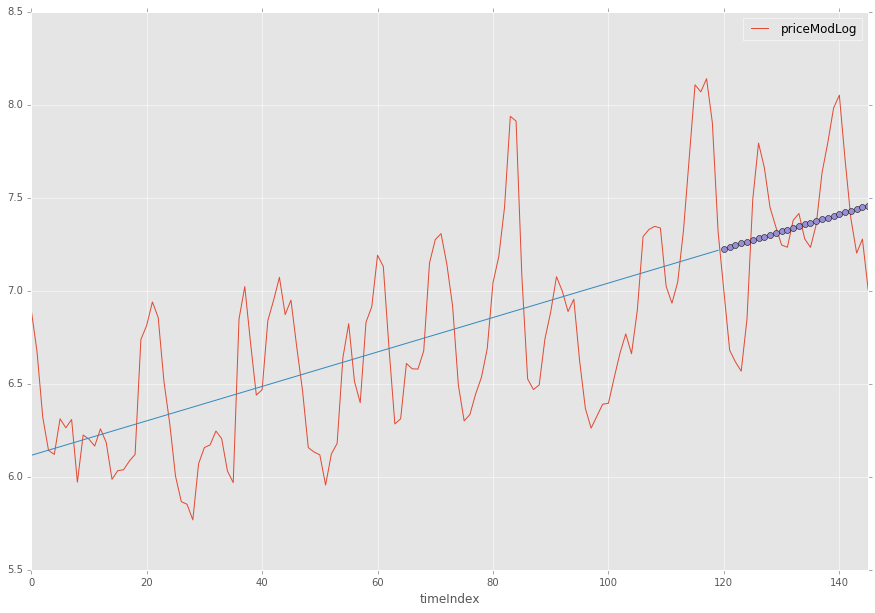

In [102]:
# Plot the prediction line
dfBang.plot(kind="line", x="timeIndex", y = "priceModLog")
plt.plot(train.timeIndex, train_linear_pred, '-')
plt.plot(test.timeIndex, test_linear_pred, 'o')

In [105]:
dfBang["priceLinear"] = np.concatenate([np.exp(train_linear_pred), np.exp(test_linear_pred)])

In [106]:
dfBang.head()

,quantity,priceMod,date,priceModLog,timeIndex,priceMean,priceLinear
2004-01,227832,991,2004-01-01,6.898715,0,785.692536,452.804569
2004-02,225133,793,2004-02-01,6.675823,1,785.692536,457.018049
2004-03,221952,556,2004-03-01,6.320768,2,785.692536,461.270737
2004-04,185150,465,2004-04-01,6.142037,3,785.692536,465.562998
2004-05,137390,455,2004-05-01,6.120297,4,785.692536,469.895199


In [110]:
# Root Mean Squared Error (RMSE)
model_linear_MSE = (test.priceMod - np.exp(test_linear_pred))**2
model_linear_RMSE = np.sqrt(model_linear_MSE.sum()/model_linear_MSE.count())
model_linear_RMSE

584.11525869256957

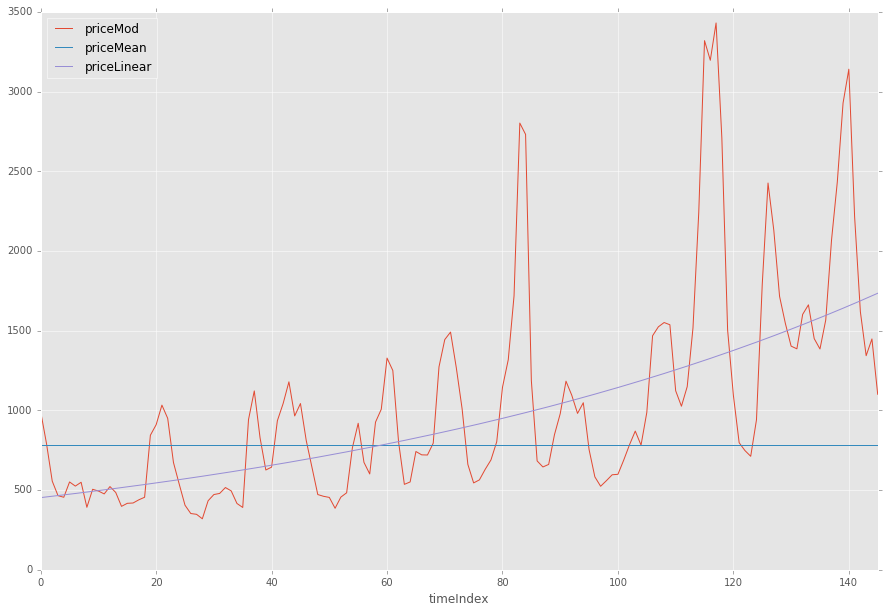

In [111]:
dfBang.plot(kind="line", x="timeIndex", y = ["priceMod", "priceMean", "priceLinear"])

## Random Walk Model

When faced with a time series that shows irregular growth, the best strategy may not be to try to directly predict the level of the series at each period (i.e., the quantity Yt). Instead, it may be better to try to predict the change that occurs from one period to the next (i.e., the quantity Yt - Yt-1). That is, it may be better to look at the first difference of the series, to see if a predictable pattern can be found there. For purposes of one-period-ahead forecasting, it is just as good to predict the next change as to predict the next level of the series, since the predicted change can be added to the current level to yield a predicted level. The simplest case of such a model is one that always predicts that the next change will be zero, as if the series is equally likely to go up or down in the next period regardless of what it has done in the past.


**Random Walk Model** $$ \hat{Y_t} = Y_{t-1} + \epsilon \\$$

**Random Walk Model with drift** $$ \hat{Y_t} = Y_{t-1} + c + \epsilon \\$$

In [112]:
train.head()

,quantity,priceMod,date,priceModLog,timeIndex,priceMean
2004-01,227832,991,2004-01-01,6.898715,0,785.692536
2004-02,225133,793,2004-02-01,6.675823,1,785.692536
2004-03,221952,556,2004-03-01,6.320768,2,785.692536
2004-04,185150,465,2004-04-01,6.142037,3,785.692536
2004-05,137390,455,2004-05-01,6.120297,4,785.692536


In [119]:
train["priceModLogShift1"] = train.priceModLog.shift()

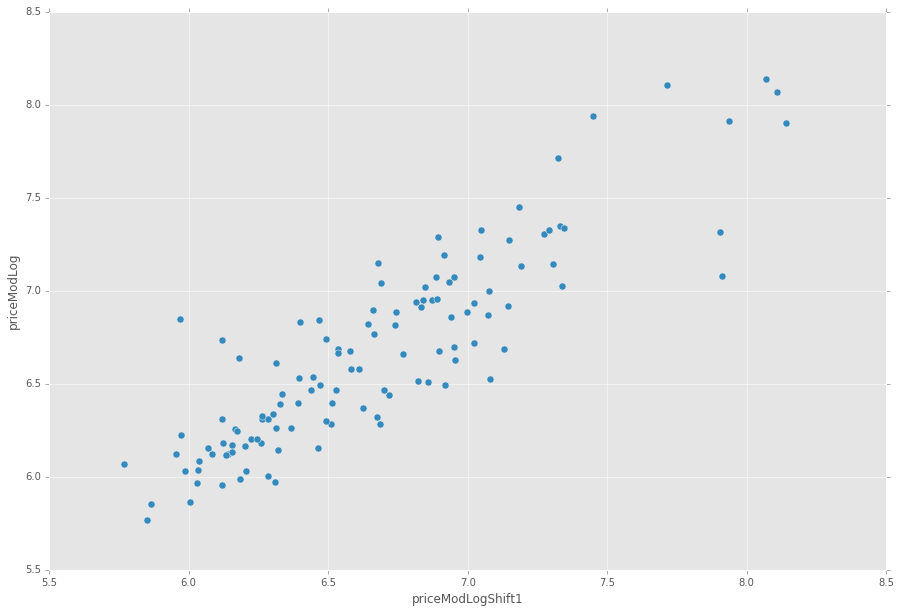

In [121]:
train.plot(kind= "scatter", y = "priceModLog", x = "priceModLogShift1", s = 50)

In [122]:
# Lets plot the one-month difference curve
train_diff = train.priceModLog - train.priceModLog.shift()

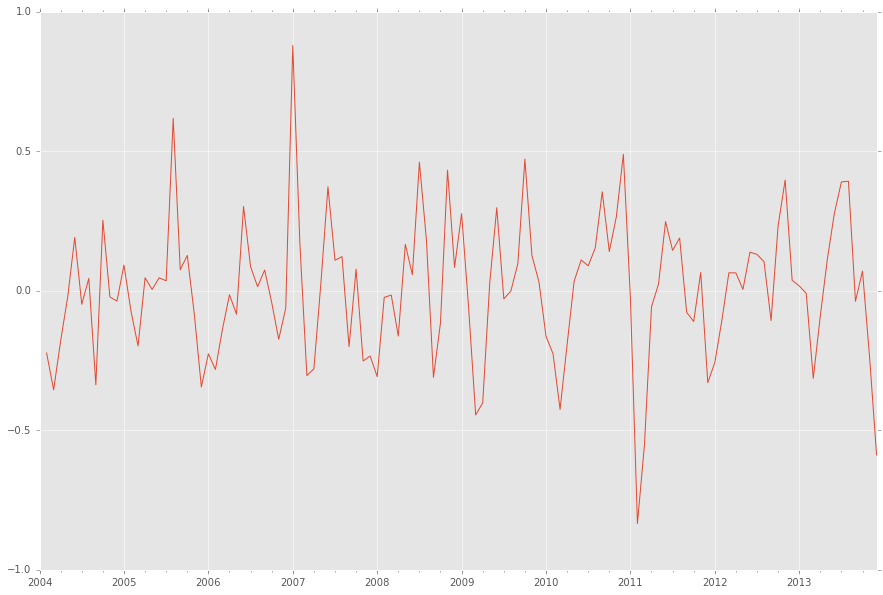

In [123]:
train_diff.plot()

In [124]:
# What is the last value in the train set
train.priceMod[-1]

1504

In [125]:
test["priceRandom"] = train.priceMod[-1]

In [126]:
dfBang["priceRandom"] = np.concatenate([train.priceModShift1, test.priceRandom])
dfBang.head()

,quantity,priceMod,date,priceModLog,timeIndex,priceMean,priceLinear,priceRandom
2004-01,227832,991,2004-01-01,6.898715,0,785.692536,452.804569,NaN
2004-02,225133,793,2004-02-01,6.675823,1,785.692536,457.018049,991
2004-03,221952,556,2004-03-01,6.320768,2,785.692536,461.270737,793
2004-04,185150,465,2004-04-01,6.142037,3,785.692536,465.562998,556
2004-05,137390,455,2004-05-01,6.120297,4,785.692536,469.895199,465


In [127]:
dfBang.tail()

,quantity,priceMod,date,priceModLog,timeIndex,priceMean,priceLinear,priceRandom
2015-10,1612160,2215,2015-10-01,7.703008,141,785.692536,1671.439233,1504
2015-11,1071872,1618,2015-11-01,7.388946,142,785.692536,1686.992468,1504
2015-12,513186,1343,2015-12-01,7.202661,143,785.692536,1702.690431,1504
2016-01,507223,1448,2016-01-01,7.277939,144,785.692536,1718.534468,1504
2016-02,400359,1101,2016-02-01,7.003974,145,785.692536,1734.525939,1504


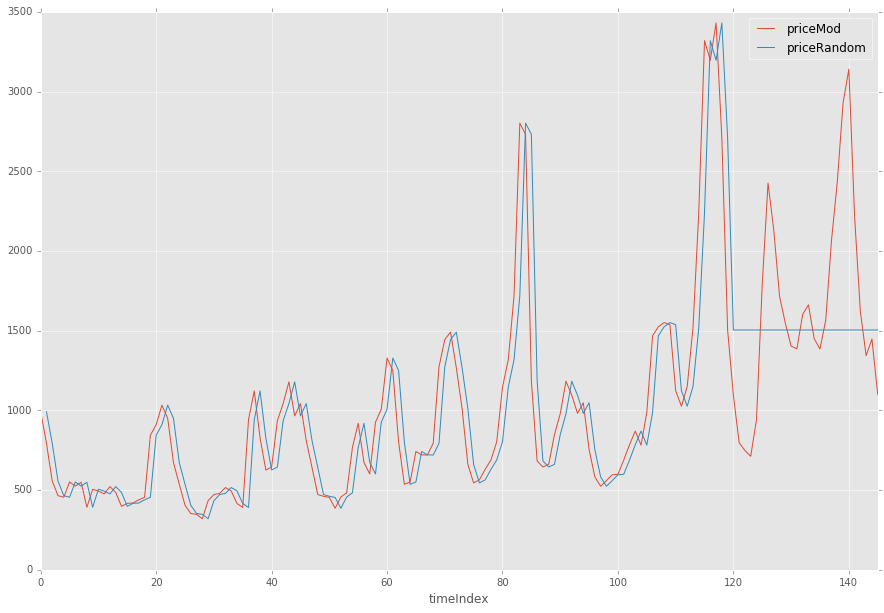

In [128]:
dfBang.plot(kind="line", x="timeIndex", y = ["priceMod","priceRandom"])

In [129]:
# Root Mean Squared Error (RMSE)
model_random_MSE = (test.priceMod - test.priceRandom)**2
model_random_RMSE = np.sqrt(model_random_MSE.sum()/model_random_MSE.count())
model_random_RMSE

627.19172629943193

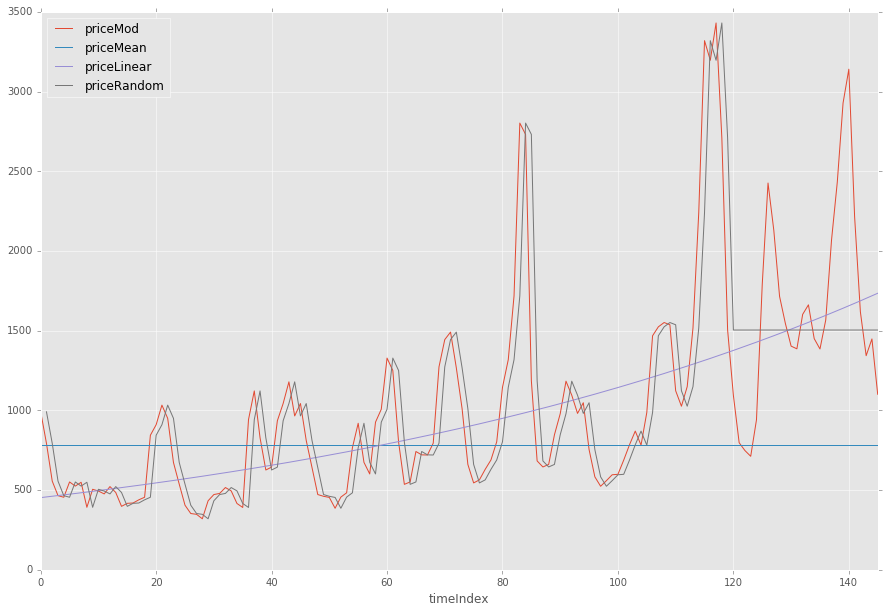

In [130]:
dfBang.plot(kind="line", x="timeIndex", y = ["priceMod", "priceMean", "priceLinear", "priceRandom"])

### Why do we do Transformation and Differencing?
- Transformations such as logarithms can help to stabilize the variance of a time series. 
- Differencing can help stabilize the mean of a time series by removing changes in the level of a time series, and so eliminating trend and seasonality.

## Simple Moving Average 

As a first step in moving beyond mean models, random walk model and linear trend models, nonseasonal patterns and trends can be extrapolated using a moving-average or smoothing model. The basic assumption behind averaging and smoothing models is that the time series is locally stationary with a slowly varying mean. Hence, we take a moving (local) average to estimate the current value of the mean and then use that as the forecast for the near future. This can be considered as a compromise between the mean model and the random-walk-without-drift-model. The same strategy can be used to estimate and extrapolate a local trend.  A moving average is often called a "smoothed" version of the original series because short-term averaging has the effect of smoothing out the bumps in the original series. By adjusting the degree of smoothing (the width of the moving average), we can hope to strike some kind of optimal balance between the performance of the mean and random walk models.

Simple Moving Average (SMA)

$$ \hat{y_t} = \frac{y_{t-1} + y_{t-2} + y_{t-3} + ... + y_{t-m}}{m} \\$$

In [144]:
# For smoothing the values we can use 12 month Moving Averages 
train['priceModLogMA12'] = pd.rolling_mean(train.priceModLog, window = 12)
train['priceModLogMA06'] = pd.rolling_mean(train.priceModLog, window = 6)

In [145]:
train.tail()

,quantity,priceMod,date,priceModLog,timeIndex,priceMean,priceModShift1,priceModLogShift1,priceModLogMA12,priceModLogMA06
2013-08,511174,3319,2013-08-01,8.107419,115,785.692536,2241,7.714677,7.250994,7.358403
2013-09,1289187,3196,2013-09-01,8.069655,116,785.692536,3319,8.107419,7.368311,7.532719
2013-10,1639032,3430,2013-10-01,8.140316,117,785.692536,3196,8.069655,7.472115,7.733867
2013-11,710266,2709,2013-11-01,7.904335,118,785.692536,3430,8.140316,7.523171,7.876815
2013-12,628220,1504,2013-12-01,7.315884,119,785.692536,2709,7.904335,7.522071,7.875381


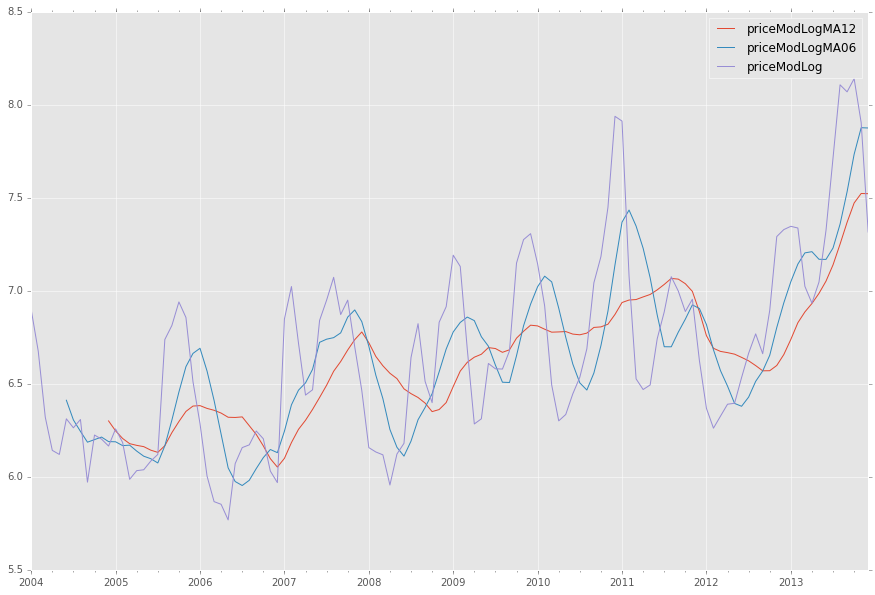

In [147]:
train.plot(kind ="line", y=["priceModLogMA12", "priceModLogMA06", "priceModLog"])

The long-term forecasts from the SMA model are a horizontal straight line, just as in the random walk model. Thus, the SMA model assumes that there is no trend in the data. However, whereas the forecasts from the random walk model are simply equal to the last observed value, the forecasts from the SMA model are equal to a weighted average of recent values.

    

In [151]:
# What is the last value in the train set
train.priceModLogMA12[-1]

7.5220706352952957

In [152]:
test['priceModLogMA12'] = train.priceModLogMA12[-1]

In [155]:
dfBang["priceMA12"] = np.concatenate([np.exp(train.priceModLogMA12), np.exp(test.priceModLogMA12)])
dfBang.tail()

,quantity,priceMod,date,priceModLog,timeIndex,priceMean,priceLinear,priceRandom,priceMA12
2015-10,1612160,2215,2015-10-01,7.703008,141,785.692536,1671.439233,1504,1848.390677
2015-11,1071872,1618,2015-11-01,7.388946,142,785.692536,1686.992468,1504,1848.390677
2015-12,513186,1343,2015-12-01,7.202661,143,785.692536,1702.690431,1504,1848.390677
2016-01,507223,1448,2016-01-01,7.277939,144,785.692536,1718.534468,1504,1848.390677
2016-02,400359,1101,2016-02-01,7.003974,145,785.692536,1734.525939,1504,1848.390677


In [159]:
# Root Mean Squared Error (RMSE)
model_MA12_MSE = (test.priceMod - np.exp(test.priceModLogMA12))**2
model_MA12_RMSE = np.sqrt(model_MA12_MSE.sum()/model_MA12_MSE.count())
model_MA12_RMSE

646.5974042458206

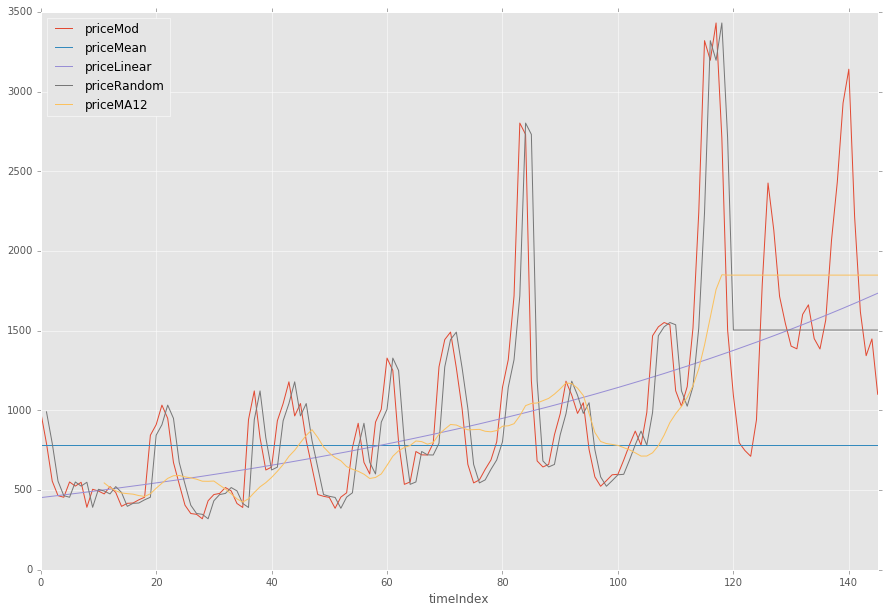

In [157]:
dfBang.plot(kind="line", x="timeIndex", y = ["priceMod", "priceMean", "priceLinear", "priceRandom", "priceMA12"])


## Simple Exponential Smoothing Model (SES)

Instead of equally weighting each of the observation, in the SES model we give more weightage to the recent observations and less to the older ones. This is done by the using a smoothing variable like alpha

$$ \hat{y_t} = \alpha y_{t-1} + (1-\alpha)\hat{y_{t-1}} \\$$

## Time Series Decomposition

- **Trend**: A trend exists when there is a long-term increase or decrease in the data. It does not have to be linear. Sometimes we will refer to a trend “changing direction” when it might go from an increasing trend to a decreasing trend.
- **Seasonal**: A seasonal pattern exists when a series is influenced by seasonal factors (e.g., the quarter of the year, the month, or day of the week). Seasonality is always of a fixed and known period.
- **Cyclic**: A cyclic pattern exists when data exhibit rises and falls that are not of fixed period. The duration of these fluctuations is usually of at least 2 years.

$$ y_t=S_t+T_t+E_t \\$$

where $y_t$ is the data at period `t`, $S_t$ is the seasonal component at period 't', $T_t$ is the trend-cycle component at period tt and $E_t$ is the remainder (or irregular or error) component at period tt. 

Alternatively, a multiplicative model would be written as

$$ y_t=S_t*T_t*E_t \\$$

The additive model is most appropriate if the magnitude of the seasonal fluctuations or the variation around the trend-cycle does not vary with the level of the time series. When the variation in the seasonal pattern, or the variation around the trend-cycle, appears to be proportional to the level of the time series, then a multiplicative model is more appropriate. With economic time series, multiplicative models are common.

An alternative to using a multiplicative model, is to first transform the data until the variation in the series appears to be stable over time, and then use an additive model. When a log transformation has been used, this is equivalent to using a multiplicative decomposition because

$$ log y_t=log S_t+ log T_t + log E_t \\$$

Sometimes, the trend-cycle component is simply called the “trend” component, even though it may contain cyclic behaviour as well.

In [ ]:
# For smoothing the values we can use 12 month Moving Averages 
priceModLogMA11 = pd.rolling_mean(train.priceModLog, window = 11)

In [ ]:
train.plot(["priceModLog", "priceModLogMA11"])

### Differencing
Transformations such as logarithms can help to stabilize the variance of a time series. Differencing can help stabilize the mean of a time series by removing changes in the level of a time series, and so eliminating trend and seasonality.

In [ ]:
train.priceMod.autocorr(lag=1)

In [ ]:
# Lets plot the one-month difference curve
train_diff = train.priceMod - train.priceMod.shift()

In [ ]:
train_diff.plot()

In [ ]:
train_diff.describe()

## AutoRegressive Models - AR(p)

In an autoregression model, we forecast the variable of interest using a linear combination of past values of the variable. The term autoregression indicates that it is a regression of the variable against itself.

Thus an autoregressive model of order (p) can be written as

$$ y_t = c + m_1y_{t-1} + m_2y_{t-2} + m_3y_{t-3} + .. \\$$

**Random walk model is an AR(1) model with ** $$m_1=1,  c = 0\\$$
**Random walk model with drift model ** $$m_1=1,  c \not= 0\\$$

We normally restrict autoregressive models to stationary data, and then some constraints on the values of the parameters are required.

For an AR(1) model:   $$ −1<m_1<−1 \\$$
For an AR(2) model:   
$$ −1<m_2<−1, m_1 + m_2 < 1, m_2 - m_1 <1 \\$$

In [ ]:
# For smoothing the values we can use
# 12 month Moving Averages 
ts_log_diff_ma = pd.rolling_mean(ts_log_diff, window = 12)

In [ ]:
# Simple Exponential Smoothing
ts_log_diff_exp = pd.ewma(ts_log_diff, halflife=24)

In [ ]:
ts_log_diff_ma.plot()
ts_log_diff_exp.plot()
ts_log_diff.plot()

Now we can fit an ARIMA model on this (Explaining ARIMA is out of scope of this workshop)

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
model = ARIMA(ts_log, order=(0, 1, 2))

In [ ]:
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='blue')

In [ ]:
train.priceMod.plot()
priceModMA12.plot()

### TIme Series Modelling

However, we have our data at constant time intervals of every month. Therefore we can analyze this data  to determine the long term trend so as to forecast the future or perform some other form of analysis. 

- Instead of using linear regression model where observations are independent, our observations are really time-dependent and we should use that.
- Second, we need to account for both a trend component and seasonality component in the time series data to better improve our forecast